# Air Quality Prediction

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

In [2]:
warnings.filterwarnings("ignore")
df = pd.read_csv(r"C:/Users/Rahul Nagarajan/Desktop/ML/Air Quality Prediction/Dataset/data.csv", encoding='cp1252')

In [3]:
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [4]:
#The original dataset has 43572 samples and 13 features
df.shape

(435742, 13)

# Data Cleaning

In [5]:
#check for missing values 
df.isnull().sum()

stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

In [6]:
def process_data(df):
    # Drop unnecessary columns
    columns_to_drop = ['agency', 'stn_code', 'date', 'sampling_date', 'location_monitoring_station']
    df = df.drop(columns_to_drop, axis=1)
    
    # Fill missing categorical data with mode
    df['location'] = df['location'].fillna(df['location'].mode()[0])
    df['type'] = df['type'].fillna(df['type'].mode()[0])
    
    # Fill other missing values with 0
    df.fillna(0, inplace=True)
    
    return df

In [7]:
df = process_data(df)

In [8]:
df.isnull().sum()

state       0
location    0
type        0
so2         0
no2         0
rspm        0
spm         0
pm2_5       0
dtype: int64

# Data Exploration

In [9]:
#The clean dataset has the same samples but 8 features 
df.shape

(435742, 8)

In [10]:
#Checking data types
df.dtypes

state        object
location     object
type         object
so2         float64
no2         float64
rspm        float64
spm         float64
pm2_5       float64
dtype: object

In [11]:
#Statistical summary
df.describe()

,so2,no2,rspm,spm,pm2_5
count,435742.000000,435742.000000,435742.000000,435742.000000,435742.000000
mean,9.968364,24.848119,98.786766,100.503296,0.871919
std,11.116635,18.801635,77.979702,150.074247,7.424595
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,13.000000,47.000000,0.000000,0.000000
50%,7.183333,21.000000,83.000000,0.000000,0.000000
75%,13.000000,32.000000,135.000000,172.000000,0.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [12]:
#First five rows
df.head()

,state,location,type,so2,no2,rspm,spm,pm2_5
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,0.0,0.0,0.0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,0.0,0.0,0.0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,0.0,0.0,0.0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,0.0,0.0,0.0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,0.0,0.0,0.0


In [13]:
#Last five rows
df.tail()

,state,location,type,so2,no2,rspm,spm,pm2_5
435737,West Bengal,ULUBERIA,RIRUO,22.0,50.0,143.0,0.0,0.0
435738,West Bengal,ULUBERIA,RIRUO,20.0,46.0,171.0,0.0,0.0
435739,andaman-and-nicobar-islands,Guwahati,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,0.0
435740,Lakshadweep,Guwahati,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,0.0
435741,Tripura,Guwahati,"Residential, Rural and other Areas",0.0,0.0,0.0,0.0,0.0


In [14]:
#Checking correlation between polutants
df[['so2', 'no2', 'rspm', 'spm', 'pm2_5']].corr()

,so2,no2,rspm,spm,pm2_5
so2,1.000000,0.369450,0.097568,0.105536,-0.019861
no2,0.369450,1.000000,0.317282,0.191618,0.018202
rspm,0.097568,0.317282,1.000000,0.196845,0.032407
spm,0.105536,0.191618,0.196845,1.000000,-0.078646
pm2_5,-0.019861,0.018202,0.032407,-0.078646,1.000000


# Feature Engineering

In [15]:
def calculate_index(val, breakpoints):
    for bp in breakpoints:
        if val <= bp[0]:
            return bp[1] * val / bp[0]
        elif val <= bp[2]:
            return bp[1] + (val - bp[0]) * (bp[3] - bp[1]) / (bp[2] - bp[0])

def calculate_aqi(si, ni, rspmi, spmi):
    return max(si, ni, rspmi, spmi)

def calculate_airquality(aqi):
    if aqi <= 50:
        return "Excellent"
    elif aqi <= 100:
        return "Acceptable"
    elif aqi <= 200:
        return "Caution"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Critical"

breakpoints = [
    (40, 50, 80, 100),
    (80, 100, 380, 200),
    (380, 200, 800, 300),
    (800, 300, 1600, 400),
    (1600, 400, float('inf'), 500)
]
df['SOi'] = df['so2'].apply(lambda x: calculate_index(x, breakpoints))

breakpoints = [
    (40, 50, 80, 100),
    (80, 100, 180, 200),
    (180, 200, 280, 300),
    (280, 300, 400, 400),
    (400, 400, float('inf'), 500)
]
df['Noi'] = df['no2'].apply(lambda x: calculate_index(x, breakpoints))

breakpoints = [
    (30, 50, 60, 100),
    (60, 100, 90, 200),
    (90, 200, 120, 300),
    (120, 300, 250, 400),
    (250, 400, float('inf'), 500)
]
df['Rpi'] = df['rspm'].apply(lambda x: calculate_index(x, breakpoints))

breakpoints = [
    (50, 50, 100, 100),
    (100, 100, 250, 200),
    (250, 200, 350, 300),
    (350, 300, 430, 400),
    (430, 400, float('inf'), 500)
]
df['SPMi'] = df['spm'].apply(lambda x: calculate_index(x, breakpoints))

df['AQI'] = df.apply(lambda x: calculate_aqi(x['SOi'], x['Noi'], x['Rpi'], x['SPMi']), axis=1)

df['Air Quality'] = df['AQI'].apply(calculate_airquality)

data = df[['state', 'location', 'SOi', 'Noi', 'Rpi', 'SPMi', 'AQI', 'Air Quality']]

In [16]:
data.head()

,state,location,SOi,Noi,Rpi,SPMi,AQI,Air Quality
0,Andhra Pradesh,Hyderabad,6.000,21.750,0.0,0.0,21.750,Excellent
1,Andhra Pradesh,Hyderabad,3.875,8.750,0.0,0.0,8.750,Excellent
2,Andhra Pradesh,Hyderabad,7.750,35.625,0.0,0.0,35.625,Excellent
3,Andhra Pradesh,Hyderabad,7.875,18.375,0.0,0.0,18.375,Excellent
4,Andhra Pradesh,Hyderabad,5.875,9.375,0.0,0.0,9.375,Excellent


In [17]:
df['so2'].describe()

count    435742.000000
mean          9.968364
std          11.116635
min           0.000000
25%           4.000000
50%           7.183333
75%          13.000000
max         909.000000
Name: so2, dtype: float64

In [18]:
df['no2'].describe()

count    435742.000000
mean         24.848119
std          18.801635
min           0.000000
25%          13.000000
50%          21.000000
75%          32.000000
max         876.000000
Name: no2, dtype: float64

In [19]:
df['rspm'].describe()

count    435742.000000
mean         98.786766
std          77.979702
min           0.000000
25%          47.000000
50%          83.000000
75%         135.000000
max        6307.033333
Name: rspm, dtype: float64

In [20]:
df['spm'].describe()

count    435742.000000
mean        100.503296
std         150.074247
min           0.000000
25%           0.000000
50%           0.000000
75%         172.000000
max        3380.000000
Name: spm, dtype: float64

# Data Visualization

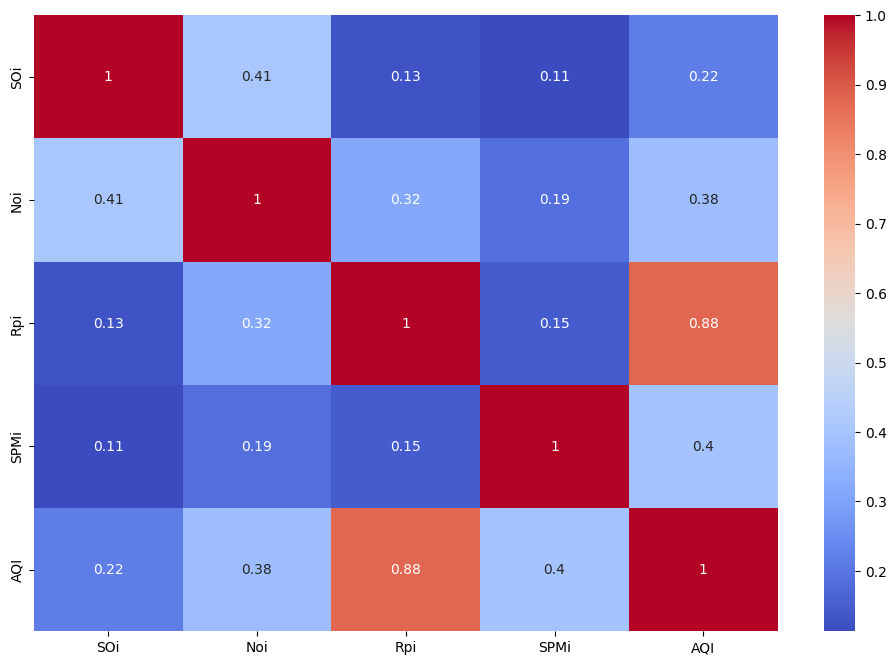

In [21]:
plt.figure(figsize=(12, 8))
corr = data.corr()  # Compute pairwise correlation of columns
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

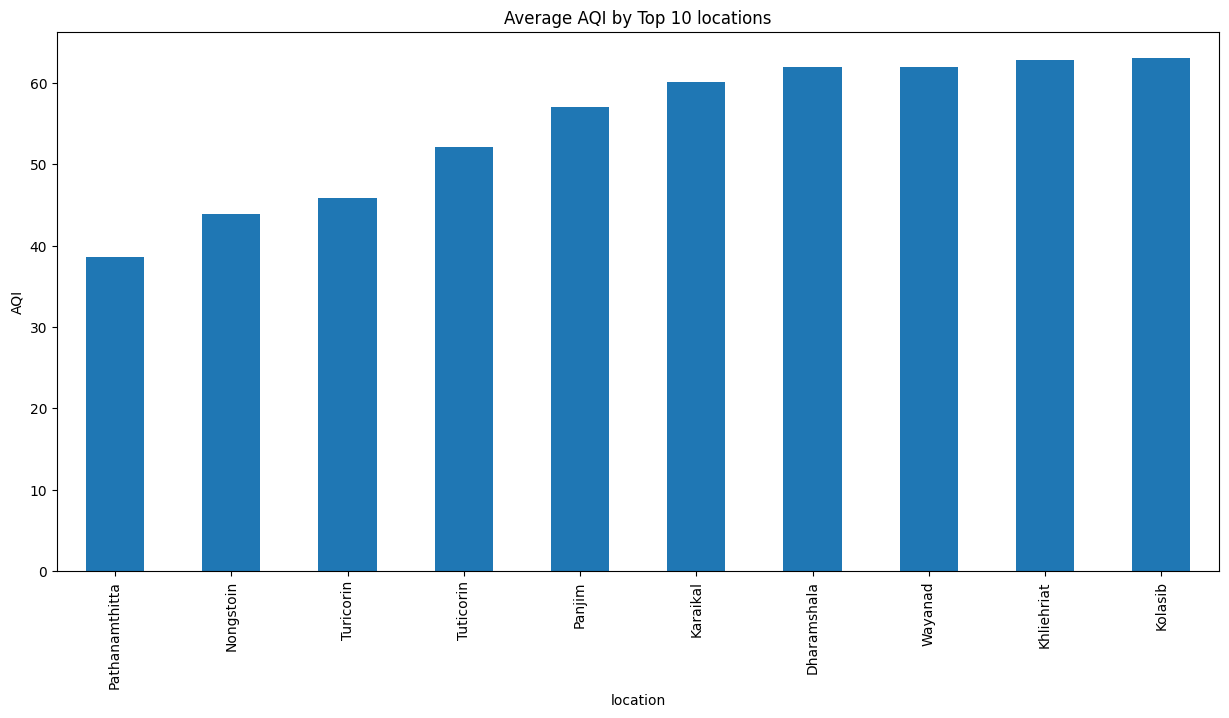

In [22]:
top_N = 10
ax = data.groupby('location')['AQI'].mean().sort_values(ascending=True).head(top_N).plot(kind='bar', figsize=(15,7))
plt.ylabel('AQI')
plt.title(f'Average AQI by Top {top_N} locations')
plt.show()

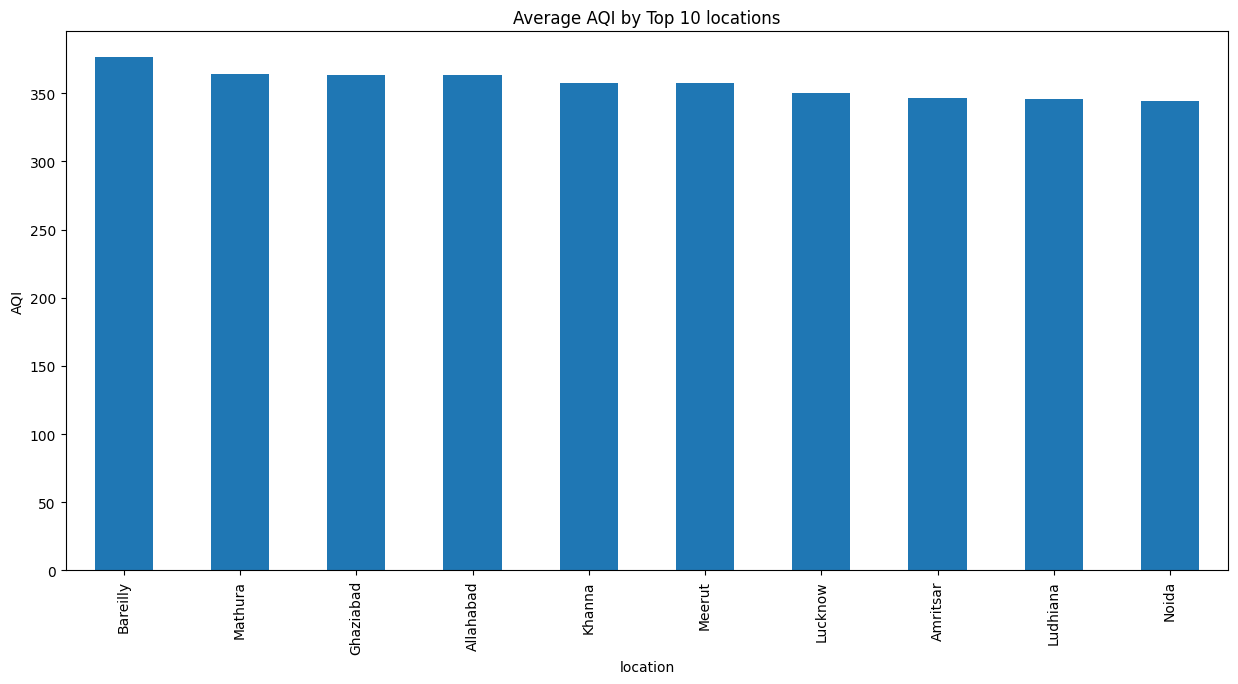

In [23]:
top_N = 10
ax = data.groupby('location')['AQI'].mean().sort_values(ascending=False).head(top_N).plot(kind='bar', figsize=(15,7))
plt.ylabel('AQI')
plt.title(f'Average AQI by Top {top_N} locations')
plt.show()

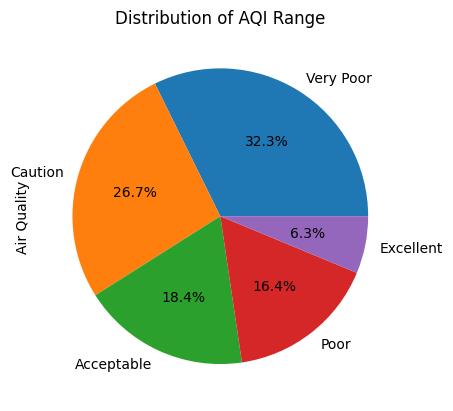

In [24]:
data['Air Quality'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of AQI Range')
plt.show()

# Modelling

In [25]:
X = data[['SOi','Noi','Rpi','SPMi']]
y = data['Air Quality']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=70)

In [27]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(291947, 4) (143795, 4) (291947,) (143795,)


In [28]:
#Using the Random Forest Classifier
RF=RandomForestClassifier().fit(X_train,y_train)
#predict on train 
pred_train = RF.predict(X_train)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(y_train, pred_train))

#predict on test
pred_test = RF.predict(X_test)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(y_test, pred_test))
print('-'*50)

# Kappa Score
print('KappaScore is: ', metrics.cohen_kappa_score(y_test, pred_test))

print("Classification Report: \n", classification_report(y_test, pred_test))

Model accuracy on train is:  1.0
Model accuracy on test is:  0.9998817761396432
--------------------------------------------------
KappaScore is:  0.9998445352909929
Classification Report: 
               precision    recall  f1-score   support

  Acceptable       1.00      1.00      1.00     26571
     Caution       1.00      1.00      1.00     38286
   Excellent       1.00      1.00      1.00      8936
        Poor       1.00      1.00      1.00     23794
   Very Poor       1.00      1.00      1.00     46208

    accuracy                           1.00    143795
   macro avg       1.00      1.00      1.00    143795
weighted avg       1.00      1.00      1.00    143795



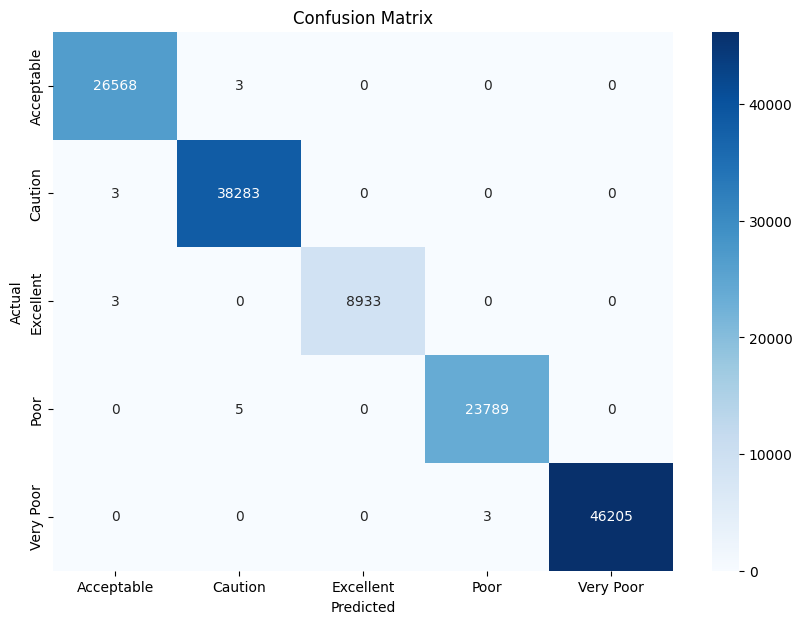

In [29]:
y_pred = RF.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=RF.classes_, yticklabels=RF.classes_) 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Testing

In [30]:
#['SOi','Noi','Rpi','SPMi']
RF.predict([[7.4,47.7,78.182,100]]) 

array(['Acceptable'], dtype=object)

In [31]:
RF.predict([[1,1.2,3.12,0]]) 

array(['Excellent'], dtype=object)

In [32]:
RF.predict([[325.7,345,798.182,203]]) 

array(['Very Poor'], dtype=object)

# Save the model

In [33]:
# joblib.dump(RF, 'RF_model.pkl')